In [1]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from spacy.symbols import nsubj, VERB, amod, acomp
import spacy
import string
nltk.download('gutenberg')

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Add neural coref to SpaCy's pipe
# https://github.com/huggingface/neuralcoref
import neuralcoref
neuralcoref.add_to_pipe(nlp)
# add dependency parser
#parser = nlp.add_pipe("parser")

from wordcloud import WordCloud, STOPWORDS #https://github.com/amueller/word_cloud
%matplotlib inline

import itertools
from gensim.models import KeyedVectors
from scipy.spatial.distance import cosine 
import numpy as np
from numpy.linalg import norm

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/naimulhoque/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
glove = KeyedVectors.load_word2vec_format('./glove_50k.bin', binary=True)

In [3]:
def make_word_cloud(freq):
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                max_words=500,
                relative_scaling=0.21,
                stopwords = [], 
                min_font_size = 10).generate_from_frequencies(freq)
    # plot the WordCloud image                        
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [4]:
# file_name = 'HP - The Philosopher Stone.txt' #
#file_name = 'test_chapter.txt'
#file_name = './sleeping_beauty.txt'
#file_name = 'pride_and_prejudice.txt'
#file_name = 'little_women.txt'
#file_name = './peter_pan.txt'
#file_name = 'sherlock_holmes.txt'
#file_name = 'great_expectations.txt'
#file_name = 'treasure_island.txt'
#file_name = 'time_machine.txt'
#file_name = 'gulliver_travels.txt'
file_name = 'anna_karenina.txt'

book = open(file_name, encoding="utf8").read()
# clean text - remove all page headers

#book = re.sub(r'\W*Page |.*J.K. Rowling\W*', ' ', book)
book = re.sub(r'\W*Chapter \W*', ' ', book)
book = book.replace('   ', ' ')

In [5]:
book

' 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its\nown way.\n\nEverything was in confusion in the Oblonskys’ house. The wife had\ndiscovered that the husband was carrying on an intrigue with a French\ngirl, who had been a governess in their family, and she had announced\nto her husband that she could not go on living in the same house with\nhim. This position of affairs had now lasted three days, and not only\nthe husband and wife themselves, but all the members of their family\nand household, were painfully conscious of it. Every person in the\nhouse felt that there was no sense in their living together, and that\nthe stray people brought together by chance in any inn had more in\ncommon with one another than they, the members of the family and\nhousehold of the Oblonskys. The wife did not leave her own room, the\nhusband had not been at home for three days. The children ran wild all\nover the house; the English governess quarreled with the housekeeper,\nan

In [6]:
#book = "Once upon a time there lived a King and a Queen, who lacked but one thing on earth to make them entirely happy. The King was young, handsome, and wealthy; the Queen had a nature as good and gentle as her face was beautiful; and they adored one another, having married for love—which among kings and queens is not always the rule. Moreover, they reigned over a kingdom at peace, and their people were devoted to them. What more, then, could they possibly want? Well, they wanted one thing very badly, and the lack of it grieved them more than words can tell. They had no child. Vows, pilgrimages, all ways were tried; yet for a long while nothing came of it all, and the poor Queen especially was in despair. At last, however, to her own and her husband's inexpressible joy, she gave birth to a daughter. As soon as the palace guns announced this event, the whole nation went wild with delight."

In [7]:
def extract_main_entity(ent):
    res = ""
    for e in ent.ents:
        if e.label_ == "PERSON":
            res = res + e.text + " "
    if res=="":
        for t in ent:
            if t.pos_=="PROPN":
                print("Extra case Entity recognition: ", t)
                res = res + t.text + " "
    return res.strip()

In [8]:
def delimiter(txt):
    limits = []
    for i, m in enumerate(re.finditer('\n\n', txt)):
        if i>0 and i%10==0:  # consider 10 paras as single entity
            limits.append(m.start())
    limits.append(len(txt))
    return limits

In [9]:
# Timeline for long doucments
# given some text and level of granularity, returns list of entities along with their index
def timeline(txt):
    char_ref = {}
    limits = delimiter(txt)
    tf = {}

    st = 0
    res = {}
    for end in limits:
        doc = nlp(txt[st:end])
        
        for t in doc:
            if t.text not in tf:
                tf[t.text] = 0
            tf[t.text] += 1
        
        for c in doc._.coref_clusters:
            # we only consider proper nouns like 'ALICE'
            main_ent = extract_main_entity(c.main)
                
            if len(main_ent)>0:
                if main_ent not in res:
                    res[main_ent] = []
                #print(str(main_entity), len(c.mentions))
                for ent in c.mentions:
                    #res.append((main_ent, st + ent.start_char))
                    res[main_ent].append((main_ent, st + ent.start_char, st + ent.end_char, ent))
                    char_ref[st + ent.start_char] = main_ent
            else:
                print("No main entity found in: ", c.main)
        st = end + 1
    
    r = []
    for k in res:
        r.extend(res[k])
    
    return r, char_ref, tf

In [10]:
# @input: disctionary with keys as entities and values as list of related words
# returns list of pairs of entites which are most distant as per the word embeddings of their characteristic words
def distance_Wordcloud(data):
    dim = len(glove["he"])
    ent_vec = {}
    for ent in data:
        if len(data[ent]) > 15:
            tmp = np.zeros((dim,), dtype=float)
            for w in data[ent]:
                if w in glove:
                    w_vec = glove[w]/norm(glove[w])
                    tmp = np.add(tmp,w_vec)
            ent_vec[ent] = tmp/len(data[ent])
     
    pairs_dist = []
    for e1, e2 in itertools.combinations(list(ent_vec.keys()),2):
        e1_vec, e2_vec = ent_vec[e1], ent_vec[e2]
        pairs_dist.append((e1+"--"+e2, round(cosine(e1_vec, e2_vec),3)))
    
    pairs_dist.sort(key=lambda x: x[1], reverse=True)
    return pairs_dist

In [11]:
# kind : 3 possible values; verb, adjective, both
# returns dict with two keys 'words' and 'dist'
# @words : dict with keys representing different entities and value as list of related words (verb, adjective or both)
# @dist : list of pairs of entities along with their distnce score
def wordcloud(txt, char_ref, kind="both"):

    # get verbs for each character
    verb = {}
    # get adjectives for each mention for each character
    adjectives = {}
    
    limits = delimiter(txt)

    st = 0
    for end in limits:
        doc = nlp(txt[st:end])
        #for sent in doc.sents:   
        #    print(sent)
            
        for t in doc:
            if t.dep == nsubj and t.head.pos == VERB:
                if st+t.idx in char_ref:
                    clus_name = char_ref[st + t.idx]
                    if clus_name not in verb:
                        verb[clus_name] = []
                    verb[clus_name].append(t.head.lemma_)

            elif t.dep == amod and t.pos_ == "ADJ":
                if st + t.head.idx in char_ref:
                    clus_name = char_ref[st + t.head.idx]
                    if clus_name not in adjectives:
                        adjectives[clus_name] = []
                    adjectives[clus_name].append(t.text) 
            elif t.dep == acomp and t.pos_ == "ADJ":
                for c in t.head.children:
                    if st + c.idx in char_ref:
                        clus_name = char_ref[st + c.idx]
                        if clus_name not in adjectives:
                            adjectives[clus_name] = []
                        adjectives[clus_name].append(t.text)
                        break
            
            # finding nouns for adjectives which don't fall in amod or acomp
            elif t.pos_ == "ADJ":    
                w = t
                noun = ""
                found = False
                while not found:
                    if st + w.head.idx in char_ref: 
                        noun = w.head
                        found = True
                        break
                    else:
                        for c in w.head.children:
                            if st + c.idx in char_ref:
                                noun = c
                                found = True
                                break
                    # reached the root node
                    if w.text==w.head.text:
                        break
                    w = w.head
                    
                if type(noun)!=str:
                    print(t, noun)
                    clus_name = char_ref[st + noun.idx]
                    if clus_name not in adjectives:
                        adjectives[clus_name] = []
                    adjectives[clus_name].append(t.text)
                    print(t, clus_name)
                else:
                    print(t, t.idx, " Not Found")
                

        st = end + 1
                    
    res = {}
    if kind=="verb":
        res["words"] = verb
    elif kind=="adjective":
        res["words"] = adjectives
    elif kind=="both":
        both = verb.copy()
        for k in adjectives:
            tmp = both[k]
            tmp.extend(adjectives[k])
            both[k] = tmp
        res["words"] = both
    res["dist"] = distance_Wordcloud(res["words"])
    return res

In [12]:
_, char_ref, tf = timeline(book)

No main entity found in:  The wife
No main entity found in:  the husband
No main entity found in:  not only
the husband and wife themselves
No main entity found in:  the
house
No main entity found in:  the stray people
Extra case Entity recognition:  Prince
Extra case Entity recognition:  Stepan
Extra case Entity recognition:  Arkadyevitch
No main entity found in:  the leather-covered sofa in his study
No main entity found in:  the pillow
on the other side
No main entity found in:  a great deal
No main entity found in:  his wife
Extra case Entity recognition:  “
No main entity found in:  his quarrel with his wife
No main entity found in:  her hand
No main entity found in:  the letter in her hand
No main entity found in:  he
No main entity found in:  his wife
No main entity found in:  people
No main entity found in:  his face
Extra case Entity recognition:  “
Extra case Entity recognition:  ’s
No main entity found in:  he
No main entity found in:  this date
No main entity found in:  his

Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  our
No main entity found in:  their
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  It
Extra case Entity recognition:  Nikolay
Extra case Entity recognition:  ’s
No main entity found in:  a man
Extra case Entity recognition:  “
No main entity found in:  his head
Extra case Entity recognition:  ’s
No main entity found in:  a paper-weight
No main entity found in:  it
Extra case Entity recognition:  “
No main entity found in:  myself
Extra case Entity recognition:  “
No main entity found in:  he
Extra case Entity recognition:  ’s
No main entity found in:  

No main entity found in:  the entrance
Extra case Entity recognition:  Levin
No main entity found in:  her
No main entity found in:  the ice
No main entity found in:  the sun
No main entity found in:  crack
skaters there
No main entity found in:  They
No main entity found in:  

No main entity found in:  his

No main entity found in:  the country
Extra case Entity recognition:  “
No main entity found in:  a queer

No main entity found in:  it
No main entity found in:  me
No main entity found in:  The conversation
No main entity found in:  the princess, who
always kept in reserve, in case a subject should be lacking, two heavy
guns—the relative advantages of classical and of modern education, and
universal military service—
Extra case Entity recognition:  “
No main entity found in:  countess
Extra case Entity recognition:  “
No main entity found in:  the peasants
No main entity found in:  it
No main entity found in:  The peasant women
Extra case Entity recognition:  Konstantin
Extra case Entity recognition:  Dmitrievitch
No main entity found in:  We
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  the spiritualists
No main entity found in:  them
No main entity found in:  this
force
No main entity found in:  a force
No main entity found in:  a new force

Extra case Entity recognition:  “
No main entity found in:  No one

No main entity found in:  it
Extra case Entity recognition:  God
Extra case Entity recognition:  Matvey
No main entity found in:  an
apparently simple incident
No main entity found in:  she
No main entity found in:  her son
Extra case Entity recognition:  “
No main entity found in:  It
No main entity found in:  a servant
No main entity found in:  them
No main entity found in:  All of them
No main entity found in:  details of a proposed dinner
party
No main entity found in:  they
No main entity found in:  A little old
man in civilian dress, arranging his gray curls before another mirror,
and diffusing an odor of scent
No main entity found in:  his
No main entity found in:  his
No main entity found in:  An officer
No main entity found in:  

No main entity found in:  the ballroom
No main entity found in:  her head
No main entity found in:  everything
No main entity found in:  her
hand
No main entity found in:  The black 

Extra case Entity recognition:  “
No main entity found in:  her little red
bag
No main entity found in:  a cushion
No main entity found in:  her feet
No main entity found in:  the train
No main entity found in:  a lamp
No main entity found in:  the left
window
No main entity found in:  the novel
No main entity found in:  a speech
Extra case Entity recognition:  “
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  the paper-knife
No main entity found in:  the train
No main entity found in:  it
No main entity found in:  he
No main entity found in:  the long waist

No main entity found in:  the old lady
No main entity found in:  the cape she had taken
off and her shawl
No main entity found in:  the door
Extra case Entity recognition:  “
No main entity found in:  the wind
No main entity found in:  lying in
wait for her
No main entity found in:  the platform
No main entity found in:  the carriages
No main entity found in:  the carriage
No main entity fo

No main entity found in:  she
Extra case Entity recognition:  Kitty
No main entity found in:  her face
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  He
No main entity found in:  it
No main entity found in:  No one
No main entity found in:  you
No main entity found in:  me
No main entity found in:  a great deal
Extra case Entity recognition:  “
Extra case Entity recognition:  Levin
No main entity found in:  she
No main entity found in:  her sister
No main entity found in:  her
face
No main entity found in:  the rustle of a skirt
No main entity found in:  the sisters
Extra case Entity recognition:  “
No main entity found in:  me
Extra case Entity recognition:  Father
No main entity found in:  Mother

No main entity found in:  they
Extra case Entity recognition:  “
No main entity found in:  itself
No main entity found in:  it
Extra case Entity recognition:  Petersburg
No main entity found in:  this great set

Extra case Entity recognition:  ’s
No

No main entity found in:  he
No main entity found in:  an even, tranquil snore
No main entity found in:  It
Extra case Entity recognition:  ’s
No main entity found in:  himself
No main entity found in:  her
No main entity found in:  his habitual tone of jeering at
anyone who should say what he was saying
No main entity found in:  the
No main entity found in:  him
No main entity found in:  a murderer
No main entity found in:  That body, robbed by him of life
No main entity found in:  all the murderer
No main entity found in:  the body
of his victim
No main entity found in:  
kisses
No main entity found in:  his hand
No main entity found in:  her face
No main entity found in:  she
No main entity found in:  her horror

Extra case Entity recognition:  “
No main entity found in:  her position

No main entity found in:  One dream
No main entity found in:  both
No main entity found in:  both were her husbands at
once, that both were lavishing caresses on her
Extra case Entity recognition:  Le

No main entity found in:  it
No main entity found in:  the forest
Extra case Entity recognition:  Ryabinin
Extra case Entity recognition:  ’s
No main entity found in:  cruel expression
No main entity found in:  a fat old pocketbook
Extra case Entity recognition:  “
No main entity found in:  the money
No main entity found in:  the door
Extra case Entity recognition:  Ryabinin
No main entity found in:  It
Extra case Entity recognition:  God
No main entity found in:  his
No main entity found in:  the clerk
No main entity found in:  This slight
No main entity found in:  it
No main entity found in:  his
Extra case Entity recognition:  “
Extra case Entity recognition:  “
No main entity found in:  Anyone who likes amalgamating
No main entity found in:  it
No main entity found in:  the peasant
No main entity found in:  a Polish speculator
Extra case Entity recognition:  “
No main entity found in:  they
No main entity found in:  We
No main entity found in:  our business
Extra case Entity recogn

No main entity found in:  myself
Extra case Entity recognition:  “
No main entity found in:  The horses who had run in the last race
No main entity found in:  her
No main entity found in:  the stallion
Extra case Entity recognition:  “
Extra case Entity recognition:  ’s
Extra case Entity recognition:  Karenin
No main entity found in:  his wife
No main entity found in:  the competitors
No main entity found in:  the pavilion

No main entity found in:  he
Extra case Entity recognition:  Frou
Extra case Entity recognition:  Frou
No main entity found in:  them
No main entity found in:  his
No main entity found in:  an English groom

No main entity found in:  people
No main entity found in:  the race
Extra case Entity recognition:  “
No main entity found in:  the reins
No main entity found in:  she
No main entity found in:  They
No main entity found in:  this race
No main entity found in:  The race
course
No main entity found in:  the pavilion
No main entity found in:  the racers
No main ent

No main entity found in:  A Russian lady
Extra case Entity recognition:  “
No main entity found in:  the man
No main entity found in:  the princess to

No main entity found in:  her daughter
Extra case Entity recognition:  “
Extra case Entity recognition:  “
Extra case Entity recognition:  “
No main entity found in:  your aunt
No main entity found in:  —Madame

No main entity found in:  the princess
Extra case Entity recognition:  ’s
Extra case Entity recognition:  “
No main entity found in:  her pressure
No main entity found in:  her hand
No main entity found in:  two little Russian girls, children
of an invalid
No main entity found in:  her husband

No main entity found in:  her
No main entity found in:  her only child
No main entity found in:  the princess
No main entity found in:  we
Extra case Entity recognition:  “
No main entity found in:  the colonel
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  another song
No main entity found in:  a

Extra case Entity recognition:  “
No main entity found in:  The birches
No main entity found in:  some
No main entity found in:  his brother
No main entity found in:  the peasants
Extra case Entity recognition:  “
No main entity found in:  my temper’ll
No main entity found in:  my scythe
No main entity found in:  his brother
Extra case Entity recognition:  “
No main entity found in:  the peasants
No main entity found in:  It
No main entity found in:  the peasants
Extra case Entity recognition:  “
No main entity found in:  the mowers
No main entity found in:  a view of the shaded cut part of the
meadow below
No main entity found in:  the peasants
Extra case Entity recognition:  Levin
Extra case Entity recognition:  ’s
No main entity found in:  his mare
No main entity found in:  a second scythe
No main entity found in:  It
No main entity found in:  sir
No main entity found in:  the scythe
No main entity found in:  the road
No main entity found in:  the master
No main entity found in:  a 

No main entity found in:  The
children
No main entity found in:  it
No main entity found in:  their mother
No main entity found in:  the two elder
ones
No main entity found in:  her
Extra case Entity recognition:  “
No main entity found in:  the country
No main entity found in:  the children
Extra case Entity recognition:  “
No main entity found in:  your cows
No main entity found in:  He
No main entity found in:  this
Extra case Entity recognition:  Darya
Extra case Entity recognition:  Alexandrovna
Extra case Entity recognition:  “
No main entity found in:  his face
Extra case Entity recognition:  “
No main entity found in:  this
No main entity found in:  it
No main entity found in:  her
No main entity found in:  it
Extra case Entity recognition:  “
No main entity found in:  we
No main entity found in:  it
No main entity found in:  trust,—a girl
Extra case Entity recognition:  “
No main entity found in:  the heart
No main entity found in:  a girl

No main entity found in:  his heart


No main entity found in:  her son
No main entity found in:  a support
No main entity found in:  her husband
No main entity found in:  his
No main entity found in:  his governess
No main entity found in:  the flowers
Extra case Entity recognition:  “
No main entity found in:  her son
No main entity found in:  that

No main entity found in:  him
Extra case Entity recognition:  Mariette
No main entity found in:  their
No main entity found in:  me
No main entity found in:  my son
No main entity found in:  the letter
No main entity found in:  my husband
No main entity found in:  Cupboards and chests
No main entity found in:  the steps
Extra case Entity recognition:  “
No main entity found in:  the letter with trembling fingers
No main entity found in:  A roll of unfolded notes
No main entity found in:  those words
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  They
No main entity found in:  my son
No main entity found in:  the letter
No main entity 

No main entity found in:  she
No main entity found in:  him
No main entity found in:  He
Extra case Entity recognition:  “
No main entity found in:  your son
Extra case Entity recognition:  Commission
Extra case Entity recognition:  June
No main entity found in:  the papers laid ready before him
No main entity found in:  his speech
No main entity found in:  the usual report
Extra case Entity recognition:  Alexey
Extra case Entity recognition:  Alexandrovitch
Extra case Entity recognition:  Commission
No main entity found in:  his
opponent
No main entity found in:  a stormy sitting
No main entity found in:  a servant
Extra case Entity recognition:  Alexey
Extra case Entity recognition:  Alexandrovitch
No main entity found in:  his secretary
No main entity found in:  her husband
No main entity found in:  his
study
No main entity found in:  not at her eyes
Extra case Entity recognition:  “
No main entity found in:  you
No main entity found in:  this
No main entity found in:  Not all wives

No main entity found in:  them
Extra case Entity recognition:  “
Extra case Entity recognition:  Whose
No main entity found in:  our
No main entity found in:  it
No main entity found in:  The people

No main entity found in:  a rational system
No main entity found in:  the people
No main entity found in:  leeches
Extra case Entity recognition:  “
No main entity found in:  schools
No main entity found in:  the people
No main entity found in:  schools, education
No main entity found in:  the
catechism
No main entity found in:  a peasant woman
No main entity found in:  her boy
No main entity found in:  the hen-roost
No main entity found in:  the people
No main entity found in:  the
baby
No main entity found in:  ’m
Extra case Entity recognition:  Sviazhsky
Extra case Entity recognition:  ’s
No main entity found in:  the process of reasoning
No main entity found in:  the day
No main entity found in:  whose name
No main entity found in:  the peasant
No main entity found in:  no system of hu

No main entity found in:  she
No main entity found in:  him
Extra case Entity recognition:  “
No main entity found in:  his
hands
No main entity found in:  his dream
No main entity found in:  myself
No main entity found in:  it
Extra case Entity recognition:  Countess
Extra case Entity recognition:  Lidia
Extra case Entity recognition:  Ivanovna
No main entity found in:  his wife
No main entity found in:  she
No main entity found in:  her husband
No main entity found in:  his eyes

No main entity found in:  a drawer
Extra case Entity recognition:  “
No main entity found in:  a portfolio in which he knew she used to put her most
important papers
No main entity found in:  a woman
No main entity found in:  An honest man and an honest woman
Extra case Entity recognition:  “
No main entity found in:  cruelty
No main entity found in:  a husband
No main entity found in:  It
No main entity found in:  her husband
Extra case Entity recognition:  “
No main entity found in:  my position
No main en

Extra case Entity recognition:  Pestsov
Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Ivanovitch
Extra case Entity recognition:  “
No main entity found in:  the government
No main entity found in:  We
No main entity found in:  we
No main entity found in:  they
No main entity found in:  my daughter
Extra case Entity recognition:  “
No main entity found in:  they
No main entity found in:  men
No main entity found in:  the old prince
Extra case Entity recognition:  Pestsov
Extra case Entity recognition:  Stepan
No main entity found in:  such a girl
Extra case Entity recognition:  “
No main entity found in:  we
No main entity found in:  the old prince
No main entity found in:  the subject
No main entity found in:  they
No main entity found in:  it
Extra case Entity recognition:  “
No main entity found in:  
“
Extra case Entity recognition:  “
No main entity found in:  We
No main entity found in:  soon after

No main entity found in:  he stayed and began to help her

No main entity found in:  he
No main entity found in:  she
No main entity found in:  your hand
No main entity found in:  his
face
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  you
No main entity found in:  it
No main entity found in:  the third day
Extra case Entity recognition:  “
No main entity found in:  her
No main entity found in:  my
duty
Extra case Entity recognition:  God
Extra case Entity recognition:  Alexey
Extra case Entity recognition:  Alexandrovitch
No main entity found in:  her
No main entity found in:  that husband
No main entity found in:  her
Extra case Entity recognition:  Alexey
Extra case Entity recognition:  Alexandrovitch
Extra case Entity recognition:  “
No main entity found in:  his
No main entity found in:  his head
No main entity found in:  he
No main entity found in:  His eyes
Extra case Entity recognition:  “
Extra case Entity recognition:  Alexey
Extra case Entity recognition:  Alexandrovitch
No main entity found

No main entity found in:  he
Extra case Entity recognition:  Levin
No main entity found in:  the prayers
No main entity found in:  us
Extra case Entity recognition:  Levin
No main entity found in:  thought
No main entity found in:  her
No main entity found in:  they
No main entity found in:  a corner table
No main entity found in:  her hand

No main entity found in:  her action
No main entity found in:  the lines
No main entity found in:  the deacon
Extra case Entity recognition:  ’s
Extra case Entity recognition:  Levin
Extra case Entity recognition:  ’s
No main entity found in:  haste
No main entity found in:  the altar-rails
No main entity found in:  the priest
No main entity found in:  prayers
in the official voice
Extra case Entity recognition:  “
Extra case Entity recognition:  Christ
No main entity found in:  his eyes
Extra case Entity recognition:  “
No main entity found in:  we
Extra case Entity recognition:  God
Extra case Entity recognition:  “
No main entity found in:  the 

Extra case Entity recognition:  Levin
No main entity found in:  They
No main entity found in:  his
No main entity found in:  the crowns
No main entity found in:  the priest
Extra case Entity recognition:  Kitty
No main entity found in:  the
priest and the deacon too wanted to smile just as he did
No main entity found in:  the candles
No main entity found in:  the young people
No main entity found in:  A handsome
head waiter
No main entity found in:  his hands
No main entity found in:  the head waiter
No main entity found in:  the agreement
Extra case Entity recognition:  “
No main entity found in:  the corps
Extra case Entity recognition:  ’s
No main entity found in:  them
No main entity found in:  Vronsky

Extra case Entity recognition:  “
Extra case Entity recognition:  “
No main entity found in:  he
Extra case Entity recognition:  French
No main entity found in:  it
No main entity found in:  those who looked at it
No main entity found in:  it
No main entity found in:  they
Extra cas

Extra case Entity recognition:  “
No main entity found in:  we
Extra case Entity recognition:  Work
No main entity found in:  she
No main entity found in:  him
No main entity found in:  his own thoughts
No main entity found in:  nothing
No main entity found in:  Even my ordinary pursuits I
have almost given up
No main entity found in:  this
No main entity found in:  myself
No main entity found in:  such ways
Extra case Entity recognition:  Levin
Extra case Entity recognition:  ’s
No main entity found in:  the house
Extra case Entity recognition:  ’s
No main entity found in:  her
Extra case Entity recognition:  “
No main entity found in:  an illiterate
letter
No main entity found in:  It
No main entity found in:  that woman
Extra case Entity recognition:  ’s
Extra case Entity recognition:  Nikolay
Extra case Entity recognition:  Dmitrievitch
Extra case Entity recognition:  Moscow
No main entity found in:  you
Extra case Entity recognition:  “
Extra case Entity recognition:  “
No main en

Extra case Entity recognition:  Alexey
Extra case Entity recognition:  Alexandrovitch
No main entity found in:  The other person
No main entity found in:  both
No main entity found in:  his women friends
Extra case Entity recognition:  Countess
Extra case Entity recognition:  Lidia
Extra case Entity recognition:  Ivanovna
Extra case Entity recognition:  “
No main entity found in:  Dear friend
No main entity found in:  his
No main entity found in:  her
plump hand
No main entity found in:  she
No main entity found in:  Our
No main entity found in:  He
Extra case Entity recognition:  Alexey
Extra case Entity recognition:  Alexandrovitch
Extra case Entity recognition:  Alexey
Extra case Entity recognition:  “
No main entity found in:  It
No main entity found in:  it
No main entity found in:  noble act of forgiveness
No main entity found in:  his thin voice
Extra case Entity recognition:  ’s
No main entity found in:  These pinpricks
No main entity found in:  my son
No main entity found in: 

No main entity found in:  his mother
No main entity found in:  his
No main entity found in:  His mother and
sister-in-law
No main entity found in:  his wife
Extra case Entity recognition:  “
No main entity found in:  the world
Extra case Entity recognition:  Alexey
No main entity found in:  their
Extra case Entity recognition:  “
No main entity found in:  a
man
No main entity found in:  crossed legs
No main entity found in:  the world
No main entity found in:  the world was shut on them
No main entity found in:  the world was open for him

Extra case Entity recognition:  Petersburg
No main entity found in:  the divorce
No main entity found in:  me
Extra case Entity recognition:  “
Extra case Entity recognition:  ’s
No main entity found in:  her son
No main entity found in:  things
Extra case Entity recognition:  “
Extra case Entity recognition:  Alexey
No main entity found in:  

Extra case Entity recognition:  “
Extra case Entity recognition:  Petersburg
No main entity found in:  her 

No main entity found in:  The whole family
No main entity found in:  his
Extra case Entity recognition:  “
Extra case Entity recognition:  Varenka
Extra case Entity recognition:  “
No main entity found in:  his hat
Extra case Entity recognition:  “
Extra case Entity recognition:  Varenka
Extra case Entity recognition:  ’s
No main entity found in:  the door
No main entity found in:  his
Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Ivanovitch
No main entity found in:  the terrace
No main entity found in:  the terrace 2


No main entity found in:  all the ladies of the party
No main entity found in:  the sewing and knitting of baby clothes
No main entity found in:  afternoon jam
No main entity found in:  the raspberries
No main entity found in:  The princess
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  it
No main entity found in:  the
clinging jam
Extra case Entity recognition:  “
No main entity found in:  A charming pa

No main entity found in:  her husband
Extra case Entity recognition:  “
No main entity found in:  the chestnut on the right
No main entity found in:  it
No main entity found in:  the steps
No main entity found in:  a new staircase
No main entity found in:  the carpenter
No main entity found in:  my word
No main entity found in:  the carpenter
No main entity found in:  It
Extra case Entity recognition:  “
No main entity found in:  three steps
No main entity found in:  it
No main entity found in:  it
No main entity found in:  they
Extra case Entity recognition:  “
No main entity found in:  the coachman
No main entity found in:  our
Extra case Entity recognition:  Gvozdyov
No main entity found in:  It
No main entity found in:  they

Extra case Entity recognition:  “
Extra case Entity recognition:  Vassenka
Extra case Entity recognition:  Veslovsky
No main entity found in:  the dogs
No main entity found in:  the marsh
No main entity found in:  they
Extra case Entity recognition:  Laska
No 

Extra case Entity recognition:  Darya
Extra case Entity recognition:  Alexandrovna
Extra case Entity recognition:  “
No main entity found in:  her
Extra case Entity recognition:  “
Extra case Entity recognition:  ’s
No main entity found in:  the world
No main entity found in:  it
Extra case Entity recognition:  Fanny
Extra case Entity recognition:  Masha
No main entity found in:  
The mother
Extra case Entity recognition:  “
Extra case Entity recognition:  ’s
Extra case Entity recognition:  Vassenka
No main entity found in:  He
No main entity found in:  they
No main entity found in:  the fragment
Extra case Entity recognition:  “
No main entity found in:  the
end
Extra case Entity recognition:  “
No main entity found in:  the reason
No main entity found in:  me
Extra case Entity recognition:  “
Extra case Entity recognition:  Levin
No main entity found in:  the
avenue
No main entity found in:  the trap
No main entity found in:  the princess
Extra case Entity recognition:  Levin
Extra c

No main entity found in:  This new
building
No main entity found in:  the hospital
No main entity found in:  the
ladies
No main entity found in:  only the parquet
floor
No main entity found in:  the carpenters, who were planing a
block of it
Extra case Entity recognition:  “
No main entity found in:  the reception room
No main entity found in:  they
Extra case Entity recognition:  “
Extra case Entity recognition:  Russia
No main entity found in:  his
No main entity found in:  the chair
No main entity found in:  The patient
Extra case Entity recognition:  Darya
Extra case Entity recognition:  Alexandrovna
Extra case Entity recognition:  Vronsky
Extra case Entity recognition:  “
No main entity found in:  the princess
No main entity found in:  I escort
the princess home
No main entity found in:  they
No main entity found in:  he
Extra case Entity recognition:  “
No main entity found in:  us
No main entity found in:  he
No main entity found in:  that position
Extra case Entity recognition:

No main entity found in:  the others
Extra case Entity recognition:  Hliustov
No main entity found in:  the opposition
Extra case Entity recognition:  “
No main entity found in:  We
Extra case Entity recognition:  Sviazhsky
Extra case Entity recognition:  ’s
Extra case Entity recognition:  Kostya
No main entity found in:  the marshal of the
province
No main entity found in:  the
province
No main entity found in:  the old party
No main entity found in:  

No main entity found in:  everyone
No main entity found in:  the big room
Extra case Entity recognition:  “
No main entity found in:  him
No main entity found in:  the act
Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Ivanovitch
Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Ivanovitch
No main entity found in:  the act
No main entity found in:  his
No main entity found in:  the table
Extra case Entity recognition:  “
No main entity found in:  the marshal of the province
No main entity fo

No main entity found in:  he
No main entity found in:  a little cough
No main entity found in:  her
Extra case Entity recognition:  “
Extra case Entity recognition:  Sokolov
No main entity found in:  ’m
No main entity found in:  mamma
No main entity found in:  we
No main entity found in:  things
No main entity found in:  questioningly
on him
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  She
No main entity found in:  We
Extra case Entity recognition:  ’s
Extra case Entity recognition:  Lvov
No main entity found in:  It
Extra case Entity recognition:  Arseny
Extra case Entity recognition:  ’s
Extra case Entity recognition:  “
Extra case Entity recognition:  Beauty
No main entity found in:  the country
Extra case Entity recognition:  “
Extra case Entity recognition:  Moscow
No main entity found in:  their
No main entity found in:  a heavy carriage
No main entity found in:  the country
No main entity found in:  liveries for his footmen and hall-po

Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  he

No main entity found in:  it
No main entity found in:  a book bound in morocco
Extra case Entity recognition:  “
Extra case Entity recognition:  Liza
Extra case Entity recognition:  Mertsalova
No main entity found in:  him
No main entity found in:  her face
No main entity found in:  that expression on her face
No main entity found in:  her portrait
Extra case Entity recognition:  ’s
Extra case Entity recognition:  Vorkuev
Extra case Entity recognition:  Stepan
Extra case Entity recognition:  Arkadyevitch
No main entity found in:  he
No main entity found in:  his hand
Extra case Entity recognition:  “
No main entity found in:  your wife
No main entity found in:  it
No main entity found in:  he
Extra case Entity recognition:  Levin
Extra case Entity recognition:  “
No main entity found in:  an extraordinary woman
No main entity found in:  two
letters
Extra case Entity recognition:  Sokolov
No mai

Extra case Entity recognition:  Volgarinov
Extra case Entity recognition:  “
No main entity found in:  it
No main entity found in:  me
No main entity found in:  pity on her
No main entity found in:  her
Extra case Entity recognition:  “
No main entity found in:  a divorce
No main entity found in:  the matter was ended
Extra case Entity recognition:  Alexandrovitch
No main entity found in:  this:
her position is intolerable
No main entity found in:  you
No main entity found in:  it
Extra case Entity recognition:  Alexey
Extra case Entity recognition:  Alexandrovitch
No main entity found in:  divorce
No main entity found in:  

Extra case Entity recognition:  Moscow
No main entity found in:  his
Extra case Entity recognition:  “
No main entity found in:  us
No main entity found in:  it
No main entity found in:  a man
No main entity found in:  his hand
Extra case Entity recognition:  “
Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Alexyevitch
No main entity found 

No main entity found in:  his beefsteak
Extra case Entity recognition:  “
No main entity found in:  these rooms
Extra case Entity recognition:  Wilson
Extra case Entity recognition:  ’s
No main entity found in:  a receipt
No main entity found in:  a telegram
No main entity found in:  her
Extra case Entity recognition:  “
No main entity found in:  he
No main entity found in:  me
No main entity found in:  she
No main entity found in:  flushing crimson
Extra case Entity recognition:  Yashvin
No main entity found in:  this news

Extra case Entity recognition:  Definiteness
No main entity found in:  your sake
Extra case Entity recognition:  “
No main entity found in:  he
No main entity found in:  her
No main entity found in:  His
No main entity found in:  she
Extra case Entity recognition:  “
No main entity found in:  She
No main entity found in:  her cup
No main entity found in:  her little finger
No main entity found in:  
her lips
No main entity found in:  him
Extra case Entity recogniti

No main entity found in:  the book
No main entity found in:  a critical article
Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Ivanovitch
No main entity found in:  the author of the article
No main entity found in:  The critic
No main entity found in:  an interpretation
No main entity found in:  he
No main entity found in:  the article
No main entity found in:  this subject
No main entity found in:  the subject
Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Ivanovitch
No main entity found in:  the whole people
No main entity found in:  The public
Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Ivanovitch
No main entity found in:  the country
No main entity found in:  people
No main entity found in:  volunteers driving up in four cabs
No main entity found in:  Ladies

Extra case Entity recognition:  Sergey
Extra case Entity recognition:  Ivanovitch
No main entity found in:  myself, princess
Extra case Entity recognit

No main entity found in:  

No main entity found in:  he was
No main entity found in:  the men who showed these qualities
themselves
No main entity found in:  the rye and oats
Extra case Entity recognition:  Russia
No main entity found in:  his wife and sister-in-law
No main entity found in:  the
new thatch roof
Extra case Entity recognition:  “
No main entity found in:  them
No main entity found in:  her
No main entity found in:  they
No main entity found in:  they
No main entity found in:  them
No main entity found in:  this
No main entity found in:  his watch
No main entity found in:  the machine
No main entity found in:  land
No main entity found in:  a former house porter
Extra case Entity recognition:  “
No main entity found in:  It
Extra case Entity recognition:  Platon
No main entity found in:  the peasant
Extra case Entity recognition:  Kirillov
No main entity found in:  it
No main entity found in:  One man
Extra case Entity recognition:  God
No main entity found in:  his soul

No main entity found in:  the sun
No main entity found in:  

No main entity found in:  the white birch
branches
No main entity found in:  The
peasant girls working in the garden
No main entity found in:  the copse
No main entity found in:  his
No main entity found in:  its
No main entity found in:  they
No main entity found in:  Two figures in dark dresses (they had been light
summer dresses when they started out)
No main entity found in:  the nurse
No main entity found in:  The rain
No main entity found in:  they
Extra case Entity recognition:  “
No main entity found in:  his soaked boots

No main entity found in:  We
No main entity found in:  he
No main entity found in:  the baby
No main entity found in:  the nurse
Extra case Entity recognition:  Levin
No main entity found in:  his wife
No main entity found in:  his
No main entity found in:  people
No main entity found in:  his brother
No main entity found in:  his
No main entity found in:  it
No main entity found in:  the nursery
N

In [304]:
len(char_ref.keys())

28075

In [325]:
res = wordcloud(book, char_ref, "both")

more 695  Not Found
wild 899  Not Found
American Alabin
American Alabin
better 2042  Not Found
more 2278  Not Found
awake 2383  Not Found
worst 3189  Not Found
happy he
happy Prince Stepan Arkadyevitch
good he
good Prince Stepan Arkadyevitch
humored he
humored Prince Stepan Arkadyevitch
last 3812  Not Found
humored 750  Not Found
younger his
younger Stepan
interesting He
interesting Stepan
dear 2406  Not Found
dear 2415  Not Found
awful 2421  Not Found
well 2527  Not Found
happy 2605  Not Found
vulgar 2833  Not Found
insoluble 3285  Not Found
least 3425  Not Found
blind He
blind Stepan Arkadyevitch
faint Matvey
faint Matvey
Alone 1581  Not Found
ready he
ready Matvey
good itself
good Stepan Arkadyevitch
pitiful itself
pitiful Stepan Arkadyevitch
right 888  Not Found
pleasant 135  Not Found
pockmarked 175  Not Found
topsy 745  Not Found
turvy 751  Not Found
Beg 800  Not Found
fragrant 270  Not Found
healthy 280  Not Found
many his
many Stepan Arkadyevitch
more his
more Stepan Arkadyevit

best 187  Not Found
unfeigned 608  Not Found
more 794  Not Found
dearest Anna
dearest Anna
slightest 2000  Not Found
contented 2026  Not Found
guilty 771  Not Found
innocent 787  Not Found
short 1039  Not Found
young 1170  Not Found
worse 1479  Not Found
overwrought 2150  Not Found
calmer 2217  Not Found
easier 673  Not Found
enough 1203  Not Found
short Anna
short Anna
more she
more Anna
other 1585  Not Found
hush her
hush Anna
same 312  Not Found
more she
more Anna
better 774  Not Found
married she
married Kitty
mournful 2380  Not Found
complex her
complex Kitty
poetic her
poetic Kitty
close 470  Not Found
tiresome 1421  Not Found
little She
little Anna
white 449  Not Found
gay 428  Not Found
narrower 470  Not Found
alarming 505  Not Found
splendid 548  Not Found
habitual Matvey
habitual Matvey
Full 648  Not Found
cheerful 1056  Not Found
half 1155  Not Found
pleasant 1204  Not Found
light 373  Not Found
soft she
soft Anna
other 2106  Not Found
strange 2205  Not Found
half 2235  Not 

hush 170  Not Found
intelligent Vronsky
intelligent Vronsky
more Vronsky
more Vronsky
uncertain 738  Not Found
non 865  Not Found
- 868  Not Found
success 869  Not Found
downy her
downy Claire
other 2881  Not Found
red 3508  Not Found
other 3861  Not Found
short 4068  Not Found
spiteful 39  Not Found
English 151  Not Found
easy it
easy ’s
difficult 557  Not Found
sure 833  Not Found
lovely 1710  Not Found
faggot 248  Not Found
Marvelous 2  Not Found
wittiest 350  Not Found
happy 776  Not Found
same 338  Not Found
clear 586  Not Found
clever 633  Not Found
French 1080  Not Found
exquisite 843  Not Found
short him
short Vronsky
swift her
swift Anna
resolute her
resolute Anna
little 55  Not Found
frowned 67  Not Found
Vlassieva 681  Not Found
much 90  Not Found
worse 99  Not Found
faintly she
faintly Princess Betsy
ill 429  Not Found
honorable 165  Not Found
confused 937  Not Found
hot 565  Not Found
full 535  Not Found
happiest 925  Not Found
wretchedest 941  Not Found
instant Alexey
ins

overtaken 231  Not Found
exciting He
exciting Mahotin
left her
left Frou-Frou
front 867  Not Found
solid 961  Not Found
ready 1672  Not Found
last 1862  Not Found
hush 2121  Not Found
nervous Frou
nervous Frou-Frou
mare the
mare Diana
dead 3053  Not Found
mare his
mare Vronsky
white he
white Vronsky
more 1409  Not Found
short 1461  Not Found
close Vronsky
close Vronsky
anxious Vronsky
anxious Vronsky
keener 3144  Not Found
difficult 3397  Not Found
mare He
mare Vronsky
wide 4537  Not Found
anxious Vronsky
anxious Vronsky
mare the
mare ’s
more she
more Vronsky
mare he
mare Vronsky
delicate He
delicate Vronsky
unable Vronsky
unable Vronsky
mare his
mare Vronsky
unable 6531  Not Found
white his
white Vronsky
unpardonable 7011  Not Found
bitterest his
bitterest Vronsky
colder He
colder Alexey Alexandrovitch
worse he
worse Alexey Alexandrovitch
worse 1997  Not Found
subtle 2205  Not Found
peaceable Alexey
peaceable Alexey Alexandrovitch
close 3874  Not Found
short her
short Alexey Alexandro

incomprehensible 232  Not Found
much Dolly
much Dolly
dowry She
dowry Dolly
roomy 1004  Not Found
comfortable 1014  Not Found
necessary he
necessary Stepan
necessary he
necessary Stepan
fishmonger 2713  Not Found
miserable 2755  Not Found
full Kitty
full Kitty
luxurious 3406  Not Found
comfortable 3474  Not Found
uddered 4112  Not Found
purplish 4231  Not Found
stringy 4241  Not Found
Impossible 4299  Not Found
open 4567  Not Found
open 4893  Not Found
hopeless 5687  Not Found
valuable 5794  Not Found
useful 5807  Not Found
peaceful Lily
peaceful Lily
least Lily
least Lily
Peaceful 7320  Not Found
more she
more Lily
more 8323  Not Found
same she
same Lily
proud she
proud Lily
less she
less Lily
own 353  Not Found
little 405  Not Found
nice 2728  Not Found
nice 2798  Not Found
same he
same Aliosha
first Tanya
first Tanya
full 5428  Not Found
wide 1868  Not Found
scared 1879  Not Found
thin 2608  Not Found
old 167  Not Found
interesting 494  Not Found
most 604  Not Found
wet 1281  Not Fo

conscious 416  Not Found
incapable 453  Not Found
red his
red Levin
betrothal his
betrothal Levin
best 2649  Not Found
simple 456  Not Found
ready 546  Not Found
absurd Levin
absurd Levin
better he
better Levin
more him
more Levin
new him
new Levin
incontestable him
incontestable Levin
ill 490  Not Found
true 1507  Not Found
low 1727  Not Found
profitable ’s
profitable ’s
possible Levin
possible Levin
aware 2102  Not Found
partial Levin
partial Levin
own Levin
own Levin
worthless 1510  Not Found
ready 2300  Not Found
Dissatisfied 2  Not Found
stupid Levin
stupid Levin
little 656  Not Found
aware 925  Not Found
vague 968  Not Found
checking 114  Not Found
whole Levin
whole Levin
full 1509  Not Found
important he
important Friedrich
simplest He
simplest Whose
own 501  Not Found
moral 723  Not Found
obvious 752  Not Found
worse 120  Not Found
worse 152  Not Found
worse 222  Not Found
worse 293  Not Found
worse 317  Not Found
peasant 876  Not Found
poor “
poor “
least 1835  Not Found
sorry

kindly his
kindly Konstantin
frightened He
frightened Levin
close She
close Mademoiselle Linon
shy herself
shy Mademoiselle Linon
happy herself
happy Mademoiselle Linon
first 136  Not Found
alone 206  Not Found
ashamed 270  Not Found
much 658  Not Found
dear 968  Not Found
dear She
dear Mademoiselle Linon
unmoved 1563  Not Found
wished 1656  Not Found
little 261  Not Found
known 268  Not Found
silent her
silent Kitty
first 537  Not Found
painful 680  Not Found
mon 1063  Not Found
delighted 83  Not Found
least she
least Kitty
least she
least Kitty
best 1626  Not Found
first 82  Not Found
agonizing 185  Not Found
more He
more Levin
more He
more Levin
cold 383  Not Found
callous 393  Not Found
unnoticed 1342  Not Found
least 1466  Not Found
pitiful he
pitiful Levin
miserable he
miserable Levin
unworthy he
unworthy Levin
non 3236  Not Found
- 3239  Not Found
negative 3426  Not Found
natured he
natured Alexey Alexandrovitch
little 820  Not Found
much He
much Alexandrovitch
amazing 1115  Not

good 253  Not Found
offensive Mihailov
offensive Mihailov
unimportant Mihailov
unimportant Mihailov
more Mihailov
more Mihailov
certain Mihailov
certain Mihailov
most she
most Anna
fleshly 2576  Not Found
other 2592  Not Found
marvelous 3141  Not Found
repainted 4378  Not Found
very 397  Not Found
subject Ivanov
subject Ivanov
untouched Ivanov
untouched Ivanov
exquisite 1482  Not Found
exquisite 1525  Not Found
fine 542  Not Found
younger 856  Not Found
flaxen 929  Not Found
past 1174  Not Found
strange 1716  Not Found
much he
much Mihailov
coldness 2686  Not Found
last he
last Mihailov
exhausted he
exhausted Mihailov
happy he
happy Mihailov
cheerful 3116  Not Found
fifth 131  Not Found
most 964  Not Found
more Vronsky
more Vronsky
sound Golenishtchev
sound Golenishtchev
reserved 2328  Not Found
disagreeable his
disagreeable Vronsky
better him
better Vronsky
first Golenishtchev
first Golenishtchev
detest 2877  Not Found
better 2950  Not Found
more 3006  Not Found
good 3644  Not Found
i

amazing she
amazing Anna
mirthful she
mirthful Anna
half she
half Anna
low Anna
low Anna
same 731  Not Found
other 824  Not Found
other 915  Not Found
tender 1409  Not Found
known 673  Not Found
same 1310  Not Found
busy ’m
busy ’m
worse 801  Not Found
whole 652  Not Found
broken 662  Not Found
half Vronsky
half Vronsky
staccato 1249  Not Found
less 2461  Not Found
uninteresting 2583  Not Found
worst he
worst Vronsky
little 3721  Not Found
angry 2107  Not Found
long 2301  Not Found
anxious 2354  Not Found
empty Kartasov
empty Kartasov
humiliating he
humiliating Vronsky
furthest he
furthest Vronsky
mean 367  Not Found
hateful 376  Not Found
disgusting 684  Not Found
straight 1059  Not Found
est 1167  Not Found
indignant Vronsky
indignant Vronsky
cried—“hideous 19  Not Found
angry 484  Not Found
vulgar 728  Not Found
calmer 813  Not Found
married her
married Kitty
thirteenth 226  Not Found
geese Kitty
geese Kitty
many Kitty
many Kitty
little Varenka
little Varenka
better 1864  Not Found


mais 180  Not Found
du 203  Not Found
guilty 990  Not Found
disgraced 1001  Not Found
same 1171  Not Found
good 1336  Not Found
humored 1341  Not Found
helpless 1655  Not Found
fourth 1711  Not Found
German 2181  Not Found
ready 3288  Not Found
smart 3416  Not Found
capable 3439  Not Found
own 4038  Not Found
comfortable 97  Not Found
strange 966  Not Found
flat she
flat Masha
intolerable 2181  Not Found
free 2496  Not Found
grieve 2602  Not Found
good 2790  Not Found
pleasing 2807  Not Found
most 3156  Not Found
hideousness 3168  Not Found
pretty Kitty
pretty Kitty
“ the
“ ’s Masha ’s Latin ’s
difficult the
difficult ’s Masha ’s Latin ’s
open 4197  Not Found
irritable 162  Not Found
peevish 173  Not Found
repulsive 219  Not Found
unhappy 278  Not Found
hard 739  Not Found
best 921  Not Found
happy Alexandrovna
happy Alexandrovna
envious Alexandrovna
envious Alexandrovna
same 2568  Not Found
fresh 2758  Not Found
good she
good Anna
beautiful 3820  Not Found
happy she
happy Anna
whetsto

pleasant He
pleasant Vronsky
Worth 367  Not Found
alone 1399  Not Found
better 1616  Not Found
cold 368  Not Found
impalpable 1147  Not Found
most 2182  Not Found
ill 2471  Not Found
own 3022  Not Found
last 3812  Not Found
glad ’m
glad ’m
glad ’m
glad ’m
adroit 918  Not Found
vexed 303  Not Found
true “
true “
unwilling “
unwilling “
cruel 167  Not Found
cruel 780  Not Found
nearer she
nearer Kitty
most Dolly
most Dolly
uneasy 820  Not Found
happy Kitty
happy Kitty
friendly She
friendly Kitty
hospitable She
hospitable Kitty
uneasy 1823  Not Found
more 1913  Not Found
afraid 2123  Not Found
more 3992  Not Found
much 4100  Not Found
sensible 4419  Not Found
dreaded 4509  Not Found
familiar she
familiar Kitty
few 571  Not Found
necessary she
necessary Kitty
more she
more Kitty
few She
few Kitty
more Levin
more Levin
more 2302  Not Found
much she
much Kitty
more she
more Kitty
much she
much Kitty
alone 371  Not Found
interested 439  Not Found
ashamed 674  Not Found
much 1100  Not Found
un

little 145  Not Found
asleep he
asleep Stepan Arkadyevitch
long he
long Stepan Arkadyevitch
disgusting 1156  Not Found
real he
real Stepan Arkadyevitch
other 1732  Not Found
insupportable 1997  Not Found
less 2644  Not Found
difficult 2780  Not Found
other 2881  Not Found
physical 3053  Not Found
alone 3171  Not Found
most 3875  Not Found
little 3982  Not Found
old she
old Anna
long she
long Anna
coarse she
coarse Anna
natural she
natural Anna
wretched she
wretched Anna
most 220  Not Found
more 1026  Not Found
mortifying 176  Not Found
same 669  Not Found
hideous 1422  Not Found
better 228  Not Found
intent he
intent Vronsky
honest 1081  Not Found
more he
more Vronsky
want 1610  Not Found
uttered she
uttered Vronsky
quarrel “
quarrel “
heartless he
heartless ’s
clear 601  Not Found
clearer 747  Not Found
alone 1161  Not Found
more 1660  Not Found
unable 93  Not Found
more 238  Not Found
wretched 323  Not Found
free 363  Not Found
wet 804  Not Found
other Anna
other Anna
more 207  Not F

alone 10  Not Found
dark he
dark Sergey Ivanovitch
ready 779  Not Found
aroused 1483  Not Found
interested 943  Not Found
silvery 2143  Not Found
just “
just “
ne’er “
ne’er “
ne’er 1245  Not Found
“ 1555  Not Found
public 2569  Not Found
other 213  Not Found
most 407  Not Found
many 930  Not Found
unjust 961  Not Found
good 1160  Not Found
single 162  Not Found
full 181  Not Found
ready 430  Not Found
most Levin
most Levin
most 784  Not Found
commune He
commune Sergey Ivanovitch
better Levin
better Levin
black 2311  Not Found
black 2439  Not Found
gleeful 2696  Not Found
close 611  Not Found
more Levin
more Levin
clung Kitty
clung Kitty
dry 181  Not Found
asleep 201  Not Found
black 906  Not Found
— 1669  Not Found
trivial 743  Not Found
definite he
definite Levin
good 2174  Not Found
other she
other Kitty
delighted 3293  Not Found
more 534  Not Found
most 817  Not Found
more 1065  Not Found
’re 1193  Not Found
nice 1200  Not Found
unattainable 1920  Not Found
topmost he
topmost Confu

KeyError: 'Claire'

In [343]:
def word_cloud_char(ch, ch2= []):
    inp = res["words"][ch]
    if len(ch2)>0:
        for c in ch2:
            inp.extend(res["words"][c])
        
    freq = {}
    for v in inp:
        if v not in freq:
            freq[v] = 0
        freq[v] += 1

    for k in freq:
        freq[k] = freq[k]/tf[k]

    make_word_cloud(freq)

In [340]:
#for ch in res["words"]:
#    print(ch, len(res["words"][ch]))
for ch in sorted(res["words"].items(), key=lambda x: len(x[1]), reverse=True):
    print(ch[0], len(ch[1]))

Levin 511
Kitty 223
Anna 215
Vronsky 184
Stepan Arkadyevitch 94
Alexey Alexandrovitch 94
“ 66
’s 56
’m 42
Sergey Ivanovitch 35
Dolly 33
Darya Alexandrovna 26
Varenka 24
Nikolay 23
Mihailov 22
Stepan 19
Seryozha 19
Betsy 19
Alexandrovna 17
Stiva 15
Golenishtchev 15
Kostya 14
Oblonsky 13
Sviazhsky 13
Veslovsky 13
Laska 13
Countess Lidia Ivanovna 11
Alexey 11
Nikolay Levin 10
Konstantin 10
Levin ’s 9
“ Lord 9
Anna Arkadyevna 9
Yashvin 9
Konstantin Levin 9
Lily 9
Anna Arkadyevna Karenina 8
God 7
Varvara 7
Sokolov 7
Lvov 7
Princess Shtcherbatskaya 6
“ Mamma 5
Mariette 5
Frou-Frou 5
Tanya 5
Stremov 5
English 5
Liza Mertsalova 5
Vozdvizhenskoe 5
Inquire 5
“ Countess Vronskaya 4
French 4
Mademoiselle Varenka 4
Sergey Ivanovitch Koznishev 4
Alexandrovitch 4
Koznishev 4
Mademoiselle Linon 4
Katavasov 4
Landau 4
her_—that 4
Prince Stepan Arkadyevitch 3
Matvey 3
Alexander 3
Pava 3
Claire 3
Venus 3
Alexey Vronsky’s 3
Madame Stahl 3
Petrov 3
Aliosha 3
Ivan 3
Friedrich 3
Karenin 3
Vassenka Veslovsky 

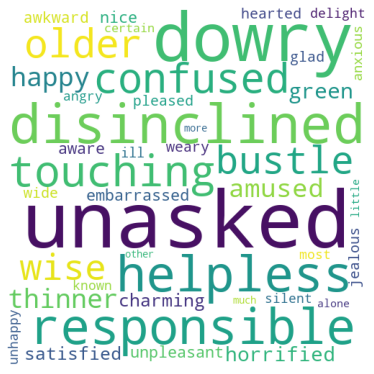

In [346]:
# Anna Karenina
word_cloud_char("Dolly", ["Darya Alexandrovna"])

In [347]:
res["words"]["Vronsky"]

['tall',
 'good',
 'handsome',
 'calm',
 'faint',
 'much',
 'other',
 'sound',
 'tedious',
 'late',
 'short',
 'faint',
 'wry',
 'bent',
 'happy',
 'only',
 'glad',
 'faint',
 'fresh',
 'more',
 'half',
 'exquisite',
 'intelligent',
 'more',
 'short',
 'fond',
 'proud',
 'aware',
 'drunk',
 'pleased',
 'pleased',
 'much',
 'pretty',
 'graceful',
 'worldly',
 'fond',
 'English',
 'sweet',
 'wry',
 'even',
 'manly',
 'much',
 'certain',
 'aware',
 'glad',
 'even',
 'better',
 'more',
 'improper',
 'enough',
 'convinced',
 'more',
 'more',
 'transparent',
 'alone',
 'irksome',
 'truthful',
 'long',
 'unnoticed',
 'discreet',
 'late',
 'tall',
 'rosier',
 'drunken',
 'afraid',
 'afraid',
 'encouraging',
 'first',
 'mare',
 'aware',
 'white',
 'close',
 'anxious',
 'aware',
 'close',
 'sure',
 'mare',
 'anxious',
 'more',
 'same',
 'mare',
 'delicate',
 'unable',
 'mare',
 'white',
 'wretched',
 'bitterest',
 'alone',
 'less',
 'wretched',
 'second',
 'false',
 'natural',
 'tempered',
 'dre

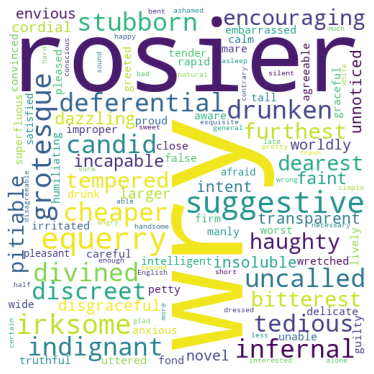

In [345]:
word_cloud_char("Vronsky")

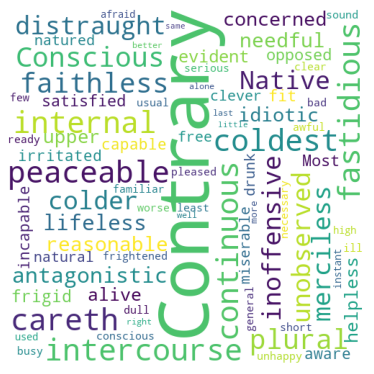

In [350]:
word_cloud_char("Alexey Alexandrovitch")

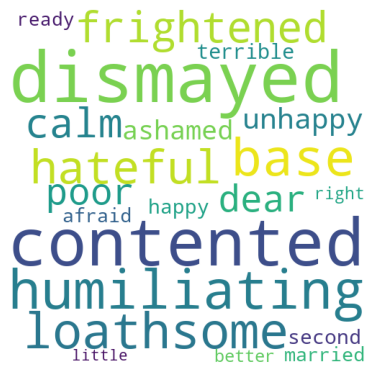

In [349]:
word_cloud_char("Nikolay")

<h3>Find all Adjectives</h3>

In [102]:
book = "The King was young, handsome, and wealthy; the Queen had a nature as good and gentle as her face was beautiful; and they adored one another, having married for love—which among kings and queens is not always the rule."
doc = nlp(book)

In [81]:
_, cr = timeline(book)

In [46]:
book[43:50], book[88:95]

('the Que', 'her fac')

In [105]:
for t in doc:
    #print(t.text, t.dep_, t.pos_)
    if t.pos_ == "ADJ":    
        w = t
        noun = ""
        found = False
        while not found:
            if w.head.pos_=="PROPN":
                noun = w.head
                found = True
                break
            else:
                for c in w.head.children:
                    if c.pos_=="PROPN":
                        noun = c
                        found = True
                        break
            # reached the root node
            if w.text==w.head.text:
                break
            w = w.head
        if type(noun)!=str:
            print(t, noun)
        else:
            print("Not Found")

young King
handsome King
wealthy King
good Queen
gentle Queen
beautiful Queen
